In [1]:
!pip install torch torchvision torchaudio

In [2]:
import torch
print(torch.cuda.is_available())

False


In [3]:
from torch import nn, optim
from torch.utils.data import dataloader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [4]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

In [5]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [6]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        return x.view(-1, 1, 28, 28)

In [10]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.fc(x)

In [11]:
# Loss & Optimizers
criterion = nn.BCELoss()
z_dim = 100
lr = 0.0002

G = Generator(z_dim)
D = Discriminator()

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [12]:
num_epochs=5
for epoch in range(num_epochs):
    for  i,(real_images,_) in enumerate(train_loader):
        real_images=real_images
        real_label = torch.full((real_images.size(0),), 1.0, dtype=torch.float)
        fake_label = torch.full((real_images.size(0),), 0.0, dtype=torch.float)

        optimizer_D.zero_grad()

        real_output=D(real_images)
        d_loss_real=criterion(real_output.view(-1),real_label)
        d_loss_real.backward()

        z=torch.randn(real_images.size(0),z_dim)
        fake_images=G(z)
        output_fake=D(fake_images.detach())

        d_loss_fake=criterion(output_fake.view(-1),fake_label)
        d_loss_fake.backward()

        d_loss=d_loss_real+d_loss_fake

        optimizer_D.step()
        optimizer_G.zero_grad()

        output_fake=D(fake_images)

        g_loss = criterion(output_fake.view(-1), real_label) 
        g_loss.backward()

        optimizer_G.step()

                 # Print progress
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Step {i}/{len(train_loader)}, "
                  f"Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")



Epoch [1/5] Step 0/938, Loss D: 1.3661, Loss G: 0.7070
Epoch [1/5] Step 100/938, Loss D: 1.3931, Loss G: 0.6783
Epoch [1/5] Step 200/938, Loss D: 1.2419, Loss G: 1.0273
Epoch [1/5] Step 300/938, Loss D: 1.1476, Loss G: 0.8519
Epoch [1/5] Step 400/938, Loss D: 1.1926, Loss G: 1.9198
Epoch [1/5] Step 500/938, Loss D: 0.9883, Loss G: 1.6651
Epoch [1/5] Step 600/938, Loss D: 0.4593, Loss G: 2.2738
Epoch [1/5] Step 700/938, Loss D: 0.9925, Loss G: 1.5298
Epoch [1/5] Step 800/938, Loss D: 0.6393, Loss G: 2.4175
Epoch [1/5] Step 900/938, Loss D: 0.7025, Loss G: 1.8523
Epoch [2/5] Step 0/938, Loss D: 0.6911, Loss G: 3.3076
Epoch [2/5] Step 100/938, Loss D: 0.5930, Loss G: 1.7750
Epoch [2/5] Step 200/938, Loss D: 0.6093, Loss G: 2.4125
Epoch [2/5] Step 300/938, Loss D: 0.6553, Loss G: 3.0386
Epoch [2/5] Step 400/938, Loss D: 0.6814, Loss G: 2.2888
Epoch [2/5] Step 500/938, Loss D: 1.4350, Loss G: 1.6843
Epoch [2/5] Step 600/938, Loss D: 1.2203, Loss G: 1.3415
Epoch [2/5] Step 700/938, Loss D: 0

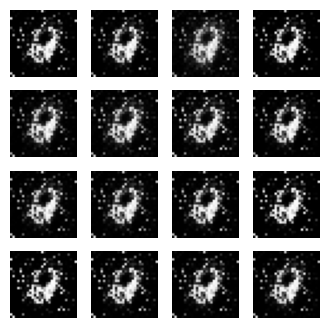

In [13]:
z = torch.randn(16, z_dim)
fake_images  = G(z)
fake_images = fake_images* 0.5 + 0.5

fig, ax = plt.subplots(4, 4, figsize=(4,4))
for i in range(4):
  for j in range(4):
    ax[i, j].imshow(fake_images[i*4 + j].detach().cpu().numpy().squeeze(), cmap='gray')
    ax[i, j].axis('off')
plt.show()